In [2]:
import numpy as np
import pandas as pd
from pylab import plt

In [3]:
steam_df = pd.read_csv("steam-200k.csv", header=None, names=['user_id', 'game', 'behavior', 'hours', '0']).drop('0', axis=1)


In [4]:
top_df = steam_df.loc[steam_df['behavior'] == 'play']
top_games_df = top_df.groupby('game').agg({'user_id':'count', 'hours':'sum'}).sort_values('user_id', ascending=False)
top_games_df = top_games_df.loc[top_games_df['user_id'] >= 10]
top_games = list(top_play_df.index)
top_play_df

,user_id,hours
game,,
Dota 2,4841,981684.6
Team Fortress 2,2323,173673.3
Counter-Strike Global Offensive,1377,322771.6
Unturned,1069,16096.4
Left 4 Dead 2,801,33596.7
...,...,...
EVGA PrecisionX 16,10,166.1
Out There Somewhere,10,26.2
FINAL FANTASY XIII-2,10,122.0


In [9]:
top_df = steam_df.loc[steam_df['behavior'] == 'play']
top_games_df = top_df.groupby('game').agg({'user_id':'count', 'hours':'sum'}).sort_values('user_id', ascending=False)
top_games_df = top_games_df.loc[top_games_df['user_id'] >= 10]
top_games = list(top_games_df.index)
top_users_df = top_df.groupby('user_id').agg({'game':'count', 'hours':'sum'}).sort_values('game', ascending=False)
top_users_df = top_users_df.loc[top_users_df['game'] >= 5]
top_users = list(top_users_df.index)
top_users_df

,game,hours
user_id,,
62990992,498,5724.8
11403772,314,6009.9
138941587,299,3011.2
47457723,298,4844.3
49893565,297,6891.9
...,...,...
129371925,5,489.4
114024939,5,1513.7
197657608,5,761.6


In [14]:
steam_df = steam_df.loc[(steam_df['game'].isin(top_games)) & (steam_df['user_id'].isin(top_users))]
purchase_df = steam_df.loc[steam_df['behavior'] == 'purchase']
play_df = steam_df.loc[steam_df['behavior'] == 'play']
print(len(purchase_df), len(play_df))

77087 50987


In [12]:
steam_df

,user_id,game,behavior,hours
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0
...,...,...,...,...
199991,128470551,Fallen Earth,play,2.4
199992,128470551,Magic Duels,purchase,1.0
199993,128470551,Magic Duels,play,2.2
199996,128470551,Grand Theft Auto Vice City,purchase,1.0


In [13]:
users = list(steam_df['user_id'].unique())
games = list(steam_df['game'].unique())
users.sort()
games.sort()
print("Unique Users: {}, Unique Games: {}".format(len(users), len(games)))

Unique Users: 2435, Unique Games: 1053


In [ ]:
A = np.zeros((len(users), len(games)))
B = np.zeros((len(users), len(games)))
print(A.shape)
for i in range(len(users)):
    user = users[i]
    print(i)
    purchased = purchase_df.loc[purchase_df['user_id'] == user]['game'].unique()
    user_play_df = play_df.loc[play_df['user_id'] == user]
    played = user_play_df['game'].unique()
    hours_played = pd.Series(user_play_df.hours.values, index=user_play_df.game).to_dict()
    for j in range(len(games)):
        game = games[j]
        A[i, j] = (hours_played[game] if game in played else 0) if game in purchased else 0
        B[i, j] = 1 if game in purchased else 0
    # entries = [(hours_played[game] if game in played else 0) if game in purchased else np.nan for game in games]
    # sparse_df = sparse_df.append([entries])

In [ ]:
np.save('/content/drive/steam.npy', A)
np.save('/content/drive/missing.npy', B)

In [15]:
class R_pca:

    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * np.linalg.norm(self.D, ord=1))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def frobenius_norm(M):
        return np.linalg.norm(M, ord='fro')

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        iter = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1E-7 * self.frobenius_norm(self.D)

        #this loop implements the principal component pursuit (PCP) algorithm
        #located in the table on page 29 of https://arxiv.org/pdf/0912.3599.pdf
        while (err > _tol) and iter < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu_inv)                            #this line implements step 3
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)             #this line implements step 4
            Yk = Yk + self.mu * (self.D - Lk - Sk)                                      #this line implements step 5
            err = self.frobenius_norm(self.D - Lk - Sk)
            iter += 1
            if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
                print('iteration: {0}, error: {1}'.format(iter, err))

        self.L = Lk
        self.S = Sk
        return Lk, Sk

    def plot_fit(self, size=None, tol=0.1, axis_on=True):

        n, d = self.D.shape

        if size:
            nrows, ncols = size
        else:
            sq = np.ceil(np.sqrt(n))
            nrows = int(sq)
            ncols = int(sq)

        ymin = np.nanmin(self.D)
        ymax = np.nanmax(self.D)
        print('ymin: {0}, ymax: {1}'.format(ymin, ymax))

        numplots = np.min([n, nrows * ncols])
        plt.figure()

        for n in range(numplots):
            plt.subplot(nrows, ncols, n + 1)
            plt.ylim((ymin - tol, ymax + tol))
            plt.plot(self.L[n, :] + self.S[n, :], 'r')
            plt.plot(self.L[n, :], 'b')
            if not axis_on:
                plt.axis('off')


In [16]:
rpca = R_pca(A)
L, S = rpca.fit(max_iter=10000, iter_print=100)

iteration: 1, error: 2.231353447036699


KeyboardInterrupt: ignored

ymin: 0.0, ymax: 33.0


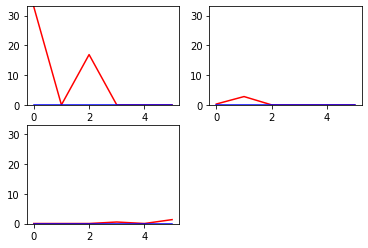

In [ ]:
# visually inspect results (requires matplotlib)
rpca.plot_fit()
plt.show()

In [ ]:
S

array([[33. , -0. , 16.9,  0. ,  0. ,  0. ],
       [ 0.3,  2.8, -0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0.5,  0. ,  1.3]])